# Phase 4A: Univariate Extreme Value Analysis

**Objective**: Analyze extreme values of Hs, Wind, and Current individually using monthly maxima (block maxima) and Peak-Over-Threshold (POT) approaches to calculate operational exceedance probabilities for offshore projects.

**Key Questions**:
1. What is the probability of exceeding operational limits during a 30-day project?
2. How does extreme current risk affect diving workability?
3. Should we avoid winter operations?

---

## PART 1: SETUP

In [11]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import gumbel_r, genextreme, weibull_min, genpareto, f_oneway, mannwhitneyu
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

## PART 2: DATA LOADING

In [12]:
# Cell 2: Load data and set index
df = pd.read_parquet('../data/processed/timeseries/UK_NortheastCoast_2015_2025_complete.parquet')

# Convert 'time' column to datetime and set as index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

print("\n" + "="*80)
print("DATA OVERVIEW")
print("="*80)
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst rows (index is now 'time'):")
display(df.head())

print("\n" + "-"*80)
print("DATA AVAILABILITY")
print("-"*80)
print(f"Hs records: {df['hs'].notna().sum():,}")
print(f"Wind records: {df['wind_speed'].notna().sum():,}")
print(f"Current records: {df['current_speed_knots_max'].notna().sum():,}")


DATA OVERVIEW
Shape: (15859, 15)
Columns: ['hs', 'tp', 'dir', 'wind_u', 'wind_v', 'wind_speed', 'month', 'month_name', 'current_velocity_mean', 'current_velocity_max', 'current_direction', 'current_u', 'current_v', 'current_speed_knots_mean', 'current_speed_knots_max']

First rows (index is now 'time'):


,hs,tp,dir,wind_u,wind_v,wind_speed,month,month_name,current_velocity_mean,current_velocity_max,current_direction,current_u,current_v,current_speed_knots_mean,current_speed_knots_max
time,,,,,,,,,,,,,,,
2015-01-01 00:00:00,1.789,5.522,201.499,5.960,10.597,12.158,1,Jan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 06:00:00,1.298,5.639,202.064,3.951,8.450,9.329,1,Jan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 12:00:00,1.801,5.403,188.970,3.231,11.774,12.210,1,Jan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 18:00:00,2.500,6.356,198.457,8.084,11.590,14.131,1,Jan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02 00:00:00,3.188,6.960,234.631,15.009,4.352,15.627,1,Jan,NaN,NaN,NaN,NaN,NaN,NaN,NaN



--------------------------------------------------------------------------------
DATA AVAILABILITY
--------------------------------------------------------------------------------
Hs records: 15,859
Wind records: 15,859
Current records: 5,611


## PART 3: MONTHLY MAXIMA ANALYSIS (Block Maxima Method)


MONTHLY MAXIMA EXTRACTION
Hs: 131 monthly maxima (10 years × 12 months)
Wind: 131 monthly maxima (10 years × 12 months)
Current: 47 monthly maxima (4 years × 12 months)


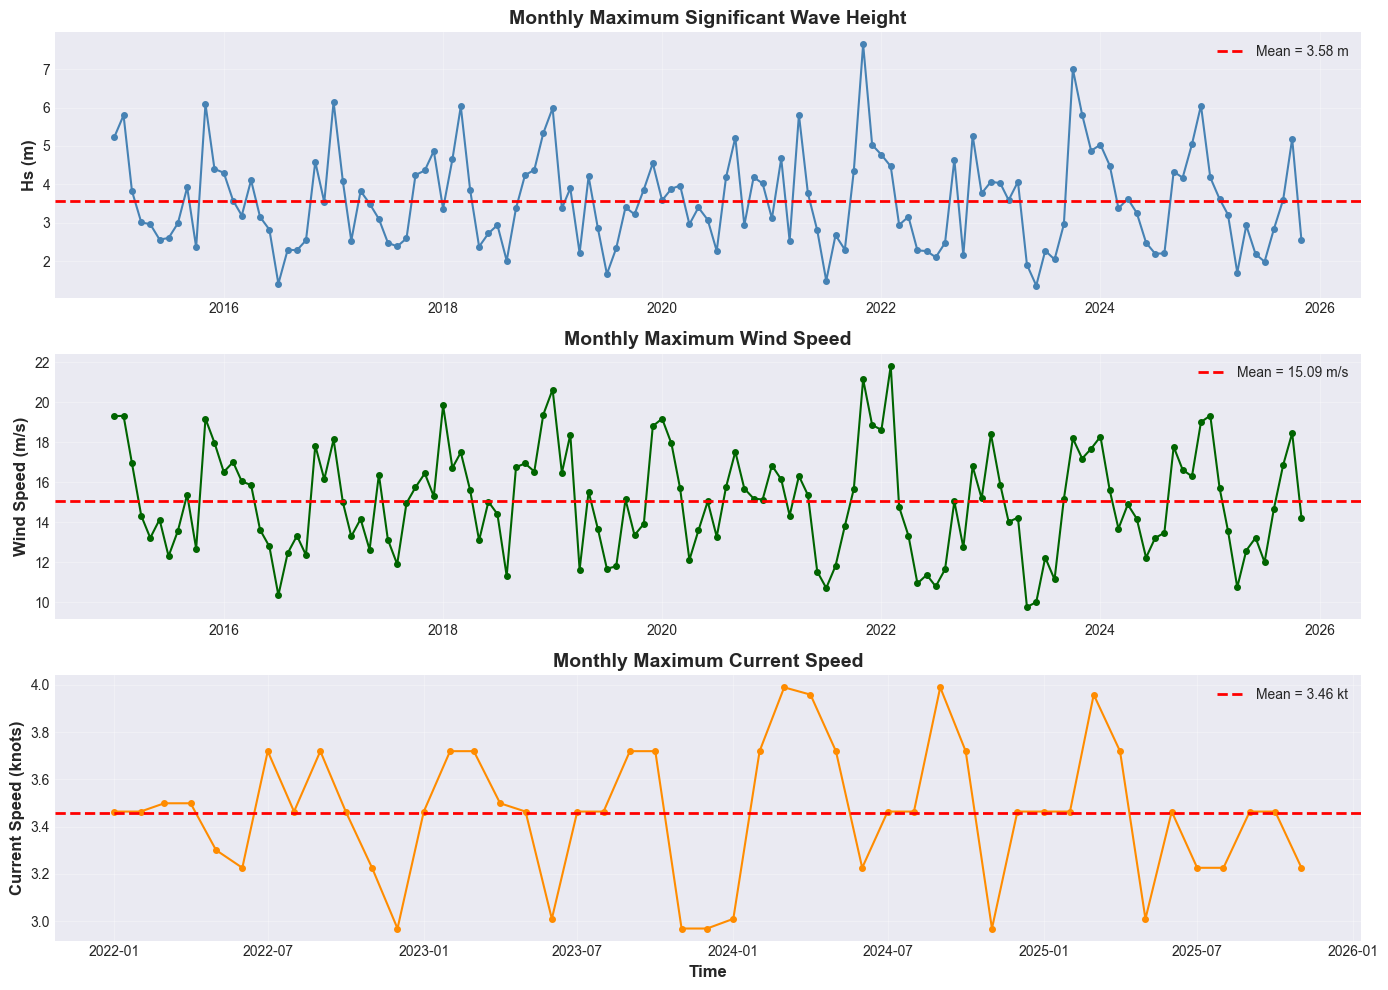


✅ Monthly maxima extracted and visualized


In [13]:
# Cell 3: Extract monthly maxima
df['year_month'] = df.index.to_period('M')

monthly_maxima_hs = df.groupby('year_month')['hs'].max().dropna()
monthly_maxima_wind = df.groupby('year_month')['wind_speed'].max().dropna()
monthly_maxima_current = df.groupby('year_month')['current_speed_knots_max'].max().dropna()

print("\n" + "="*80)
print("MONTHLY MAXIMA EXTRACTION")
print("="*80)
print(f"Hs: {len(monthly_maxima_hs)} monthly maxima (10 years × 12 months)")
print(f"Wind: {len(monthly_maxima_wind)} monthly maxima (10 years × 12 months)")
print(f"Current: {len(monthly_maxima_current)} monthly maxima (4 years × 12 months)")

# Visualize
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

axes[0].plot(monthly_maxima_hs.index.to_timestamp(), monthly_maxima_hs.values, 
             'o-', linewidth=1.5, markersize=4, color='steelblue')
axes[0].axhline(monthly_maxima_hs.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean = {monthly_maxima_hs.mean():.2f} m')
axes[0].set_ylabel('Hs (m)', fontsize=12, fontweight='bold')
axes[0].set_title('Monthly Maximum Significant Wave Height', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].plot(monthly_maxima_wind.index.to_timestamp(), monthly_maxima_wind.values, 
             'o-', linewidth=1.5, markersize=4, color='darkgreen')
axes[1].axhline(monthly_maxima_wind.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean = {monthly_maxima_wind.mean():.2f} m/s')
axes[1].set_ylabel('Wind Speed (m/s)', fontsize=12, fontweight='bold')
axes[1].set_title('Monthly Maximum Wind Speed', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

axes[2].plot(monthly_maxima_current.index.to_timestamp(), monthly_maxima_current.values, 
             'o-', linewidth=1.5, markersize=4, color='darkorange')
axes[2].axhline(monthly_maxima_current.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean = {monthly_maxima_current.mean():.2f} kt')
axes[2].set_ylabel('Current Speed (knots)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Time', fontsize=12, fontweight='bold')
axes[2].set_title('Monthly Maximum Current Speed', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Monthly maxima extracted and visualized")

In [14]:
# Cell 4: Test IID assumptions

def mann_kendall_test(data):
    """Mann-Kendall trend test. H0: no monotonic trend."""
    n = len(data)
    s = 0
    for i in range(n-1):
        for j in range(i+1, n):
            s += np.sign(data[j] - data[i])
    
    var_s = n * (n - 1) * (2 * n + 5) / 18
    
    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    else:
        z = 0
    
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    trend = 'Increasing' if (p_value < 0.05 and s > 0) else ('Decreasing' if (p_value < 0.05 and s < 0) else 'No trend')
    
    return z, p_value, trend


def test_iid_assumptions(data, name):
    """Test IID assumptions for monthly maxima."""
    print(f"\n{'='*80}")
    print(f"IID ASSUMPTIONS TEST: {name}")
    print(f"{'='*80}")
    print(f"Sample size: {len(data)} monthly maxima")
    
    # 1. Stationarity
    mk_stat, mk_pval, mk_trend = mann_kendall_test(data.values)
    print(f"\n1. STATIONARITY (Mann-Kendall):")
    print(f"   Z-statistic: {mk_stat:.3f}")
    print(f"   P-value: {mk_pval:.4f}")
    print(f"   Result: {mk_trend}")
    if mk_pval > 0.05:
        print(f"   ✅ PASS: No significant trend (p={mk_pval:.4f} > 0.05)")
    else:
        print(f"   ⚠️  WARNING: Trend detected (p={mk_pval:.4f} < 0.05)")
    
    # 2. Independence
    acf_values = acf(data, nlags=12, fft=False)
    ljung_box = acorr_ljungbox(data, lags=[12], return_df=True)
    print(f"\n2. INDEPENDENCE (Ljung-Box):")
    print(f"   Lag-1 ACF: {acf_values[1]:.3f}")
    print(f"   Ljung-Box stat (lag 12): {ljung_box['lb_stat'].values[0]:.3f}")
    print(f"   P-value: {ljung_box['lb_pvalue'].values[0]:.4f}")
    if ljung_box['lb_pvalue'].values[0] > 0.05:
        print(f"   ✅ PASS: No autocorrelation (p={ljung_box['lb_pvalue'].values[0]:.4f} > 0.05)")
    else:
        print(f"   ⚠️  WARNING: Autocorrelation detected (p={ljung_box['lb_pvalue'].values[0]:.4f} < 0.05)")
    
    # 3. Homogeneity
    months = data.index.month
    groups = [data[months == m].values for m in range(1, 13) if len(data[months == m]) > 0]
    f_stat, anova_pval = f_oneway(*groups)
    print(f"\n3. HOMOGENEITY (ANOVA by month):")
    print(f"   F-statistic: {f_stat:.3f}")
    print(f"   P-value: {anova_pval:.4f}")
    if anova_pval > 0.05:
        print(f"   ✅ PASS: No seasonal pattern (p={anova_pval:.4f} > 0.05)")
    else:
        print(f"   ⚠️  WARNING: Seasonal pattern (p={anova_pval:.4f} < 0.05)")
        print(f"   → Consider stratifying by season")
    
    return {
        'stationarity_pval': mk_pval,
        'independence_pval': ljung_box['lb_pvalue'].values[0],
        'seasonality_pval': anova_pval
    }

# Test all variables
iid_hs = test_iid_assumptions(monthly_maxima_hs, 'Hs')
iid_wind = test_iid_assumptions(monthly_maxima_wind, 'Wind')
iid_current = test_iid_assumptions(monthly_maxima_current, 'Current')


IID ASSUMPTIONS TEST: Hs
Sample size: 131 monthly maxima

1. STATIONARITY (Mann-Kendall):
   Z-statistic: -0.553
   P-value: 0.5802
   Result: No trend
   ✅ PASS: No significant trend (p=0.5802 > 0.05)

2. INDEPENDENCE (Ljung-Box):
   Lag-1 ACF: 0.387
   Ljung-Box stat (lag 12): 144.911
   P-value: 0.0000
   ⚠️  WARNING: Autocorrelation detected (p=0.0000 < 0.05)

3. HOMOGENEITY (ANOVA by month):
   F-statistic: 10.032
   P-value: 0.0000
   ⚠️  WARNING: Seasonal pattern (p=0.0000 < 0.05)
   → Consider stratifying by season

IID ASSUMPTIONS TEST: Wind
Sample size: 131 monthly maxima

1. STATIONARITY (Mann-Kendall):
   Z-statistic: -0.748
   P-value: 0.4544
   Result: No trend
   ✅ PASS: No significant trend (p=0.4544 > 0.05)

2. INDEPENDENCE (Ljung-Box):
   Lag-1 ACF: 0.532
   Ljung-Box stat (lag 12): 245.346
   P-value: 0.0000
   ⚠️  WARNING: Autocorrelation detected (p=0.0000 < 0.05)

3. HOMOGENEITY (ANOVA by month):
   F-statistic: 15.609
   P-value: 0.0000
   ⚠️  WARNING: Seasonal 

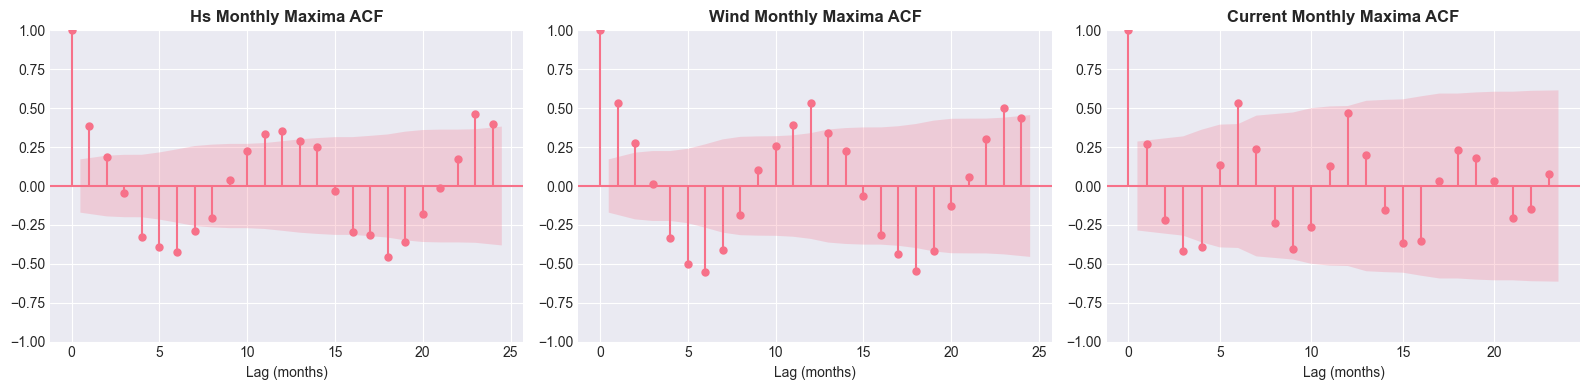

✅ ACF plots generated


In [15]:
# Cell 5: Visualize ACF
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

plot_acf(monthly_maxima_hs, lags=24, ax=axes[0], alpha=0.05)
axes[0].set_title('Hs Monthly Maxima ACF', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag (months)', fontsize=10)

plot_acf(monthly_maxima_wind, lags=24, ax=axes[1], alpha=0.05)
axes[1].set_title('Wind Monthly Maxima ACF', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag (months)', fontsize=10)

plot_acf(monthly_maxima_current, lags=min(24, len(monthly_maxima_current)//2), ax=axes[2], alpha=0.05)
axes[2].set_title('Current Monthly Maxima ACF', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Lag (months)', fontsize=10)

plt.tight_layout()
plt.show()

print("✅ ACF plots generated")

In [16]:
# Cell 6: Seasonal analysis

def get_season(month):
    """Oct-Mar = Winter, Apr-Sep = Summer."""
    return 'Winter' if month in [10, 11, 12, 1, 2, 3] else 'Summer'

# Add season column
monthly_maxima = pd.DataFrame({
    'hs': monthly_maxima_hs,
    'wind': monthly_maxima_wind,
    'current': monthly_maxima_current
})
monthly_maxima['month'] = monthly_maxima.index.month
monthly_maxima['season'] = monthly_maxima['month'].apply(get_season)

print("\n" + "="*80)
print("SEASONAL COMPARISON (Winter vs Summer)")
print("="*80)

for var in ['hs', 'wind', 'current']:
    winter = monthly_maxima[monthly_maxima['season'] == 'Winter'][var].dropna()
    summer = monthly_maxima[monthly_maxima['season'] == 'Summer'][var].dropna()
    
    u_stat, p_val = mannwhitneyu(winter, summer, alternative='two-sided')
    
    print(f"\n{var.upper()}:")
    print(f"  Winter: mean={winter.mean():.3f}, n={len(winter)}")
    print(f"  Summer: mean={summer.mean():.3f}, n={len(summer)}")
    print(f"  Difference: {winter.mean() - summer.mean():.3f} ({(winter.mean() / summer.mean() - 1) * 100:+.1f}%)")
    print(f"  Mann-Whitney U p-value: {p_val:.4f}")
    if p_val < 0.05:
        print(f"  ⚠️  Significant seasonal difference (p={p_val:.4f} < 0.05)")
    else:
        print(f"  ✅ No significant seasonal difference (p={p_val:.4f} > 0.05)")


SEASONAL COMPARISON (Winter vs Summer)

HS:
  Winter: mean=4.279, n=65
  Summer: mean=2.888, n=66
  Difference: 1.391 (+48.1%)
  Mann-Whitney U p-value: 0.0000
  ⚠️  Significant seasonal difference (p=0.0000 < 0.05)

WIND:
  Winter: mean=16.738, n=65
  Summer: mean=13.468, n=66
  Difference: 3.270 (+24.3%)
  Mann-Whitney U p-value: 0.0000
  ⚠️  Significant seasonal difference (p=0.0000 < 0.05)

CURRENT:
  Winter: mean=3.439, n=23
  Summer: mean=3.478, n=24
  Difference: -0.039 (-1.1%)
  Mann-Whitney U p-value: 0.6779
  ✅ No significant seasonal difference (p=0.6779 > 0.05)


In [17]:
# Cell 7: Fit extreme value distributions

def fit_distributions(data, name):
    """Fit Gumbel, GEV, and Weibull distributions."""
    print(f"\n{'='*80}")
    print(f"DISTRIBUTION FITTING: {name}")
    print(f"{'='*80}")
    
    results = []
    
    # Gumbel
    gumbel_params = gumbel_r.fit(data)
    gumbel_aic = 2 * 2 - 2 * np.sum(gumbel_r.logpdf(data, *gumbel_params))
    gumbel_ks = stats.kstest(data, lambda x: gumbel_r.cdf(x, *gumbel_params))
    results.append({
        'Distribution': 'Gumbel',
        'AIC': gumbel_aic,
        'KS p-value': gumbel_ks.pvalue,
        'params': gumbel_params
    })
    
    # GEV
    gev_params = genextreme.fit(data)
    gev_aic = 2 * 3 - 2 * np.sum(genextreme.logpdf(data, *gev_params))
    gev_ks = stats.kstest(data, lambda x: genextreme.cdf(x, *gev_params))
    results.append({
        'Distribution': 'GEV',
        'AIC': gev_aic,
        'KS p-value': gev_ks.pvalue,
        'params': gev_params
    })
    
    # Weibull
    weibull_params = weibull_min.fit(data)
    weibull_aic = 2 * 3 - 2 * np.sum(weibull_min.logpdf(data, *weibull_params))
    weibull_ks = stats.kstest(data, lambda x: weibull_min.cdf(x, *weibull_params))
    results.append({
        'Distribution': 'Weibull',
        'AIC': weibull_aic,
        'KS p-value': weibull_ks.pvalue,
        'params': weibull_params
    })
    
    df_results = pd.DataFrame(results).sort_values('AIC')
    display(df_results[['Distribution', 'AIC', 'KS p-value']])
    
    best = df_results.iloc[0]
    print(f"\n✅ Best fit: {best['Distribution']} (AIC={best['AIC']:.2f})")
    
    return df_results

# Fit all variables
fit_results_hs = fit_distributions(monthly_maxima_hs.values, 'Hs')
fit_results_wind = fit_distributions(monthly_maxima_wind.values, 'Wind')
fit_results_current = fit_distributions(monthly_maxima_current.values, 'Current')

# Store best fits
best_dist_hs = fit_results_hs.iloc[0]
best_dist_wind = fit_results_wind.iloc[0]
best_dist_current = fit_results_current.iloc[0]


DISTRIBUTION FITTING: Hs


,Distribution,AIC,KS p-value
2,Weibull,417.029,0.974
0,Gumbel,418.089,0.690
1,GEV,419.167,0.771



✅ Best fit: Weibull (AIC=417.03)

DISTRIBUTION FITTING: Wind


,Distribution,AIC,KS p-value
2,Weibull,622.665,0.961
1,GEV,624.634,0.944
0,Gumbel,631.744,0.321



✅ Best fit: Weibull (AIC=622.66)

DISTRIBUTION FITTING: Current


,Distribution,AIC,KS p-value
2,Weibull,18.398,0.028
1,GEV,18.468,0.045
0,Gumbel,23.864,0.003



✅ Best fit: Weibull (AIC=18.40)


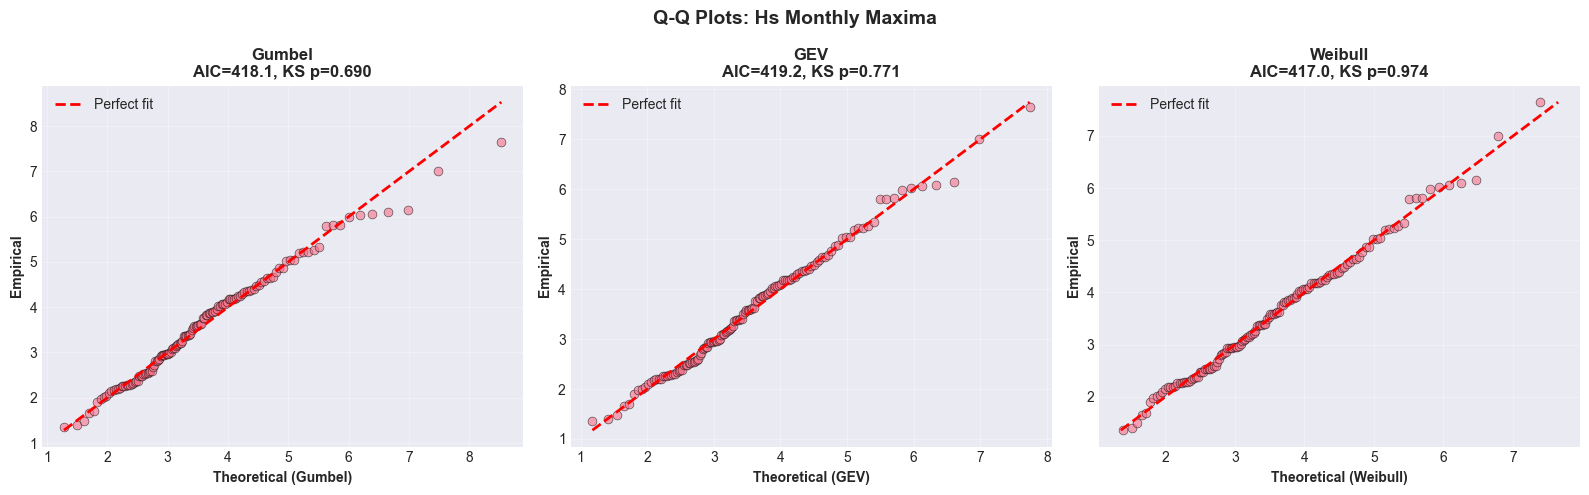

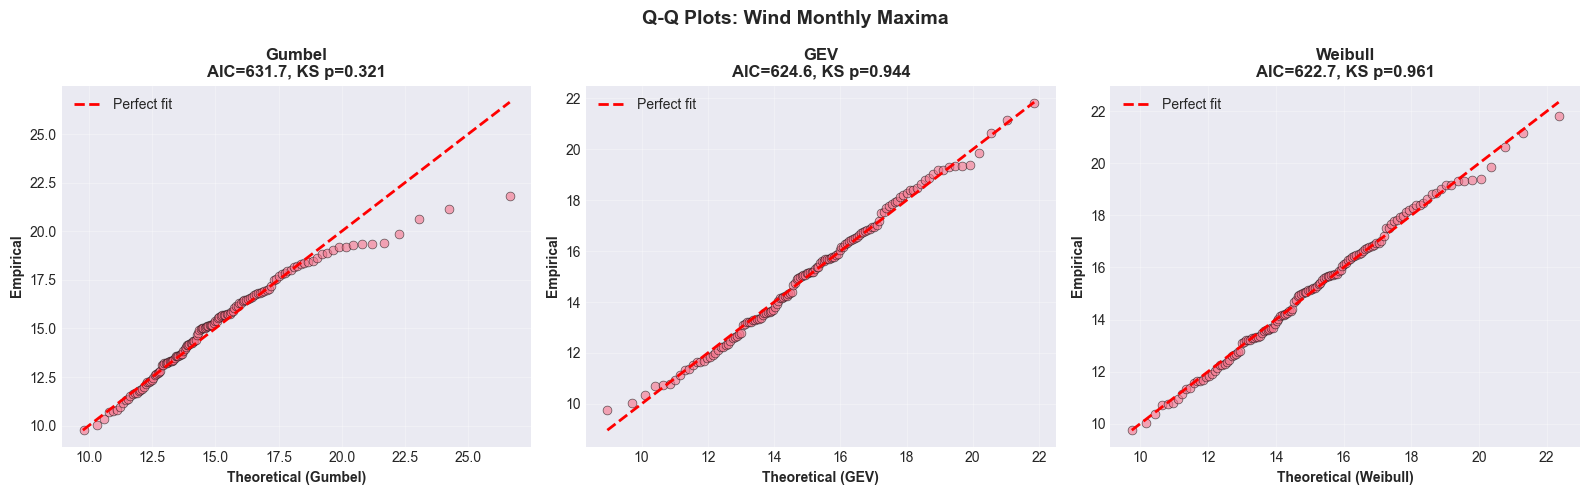

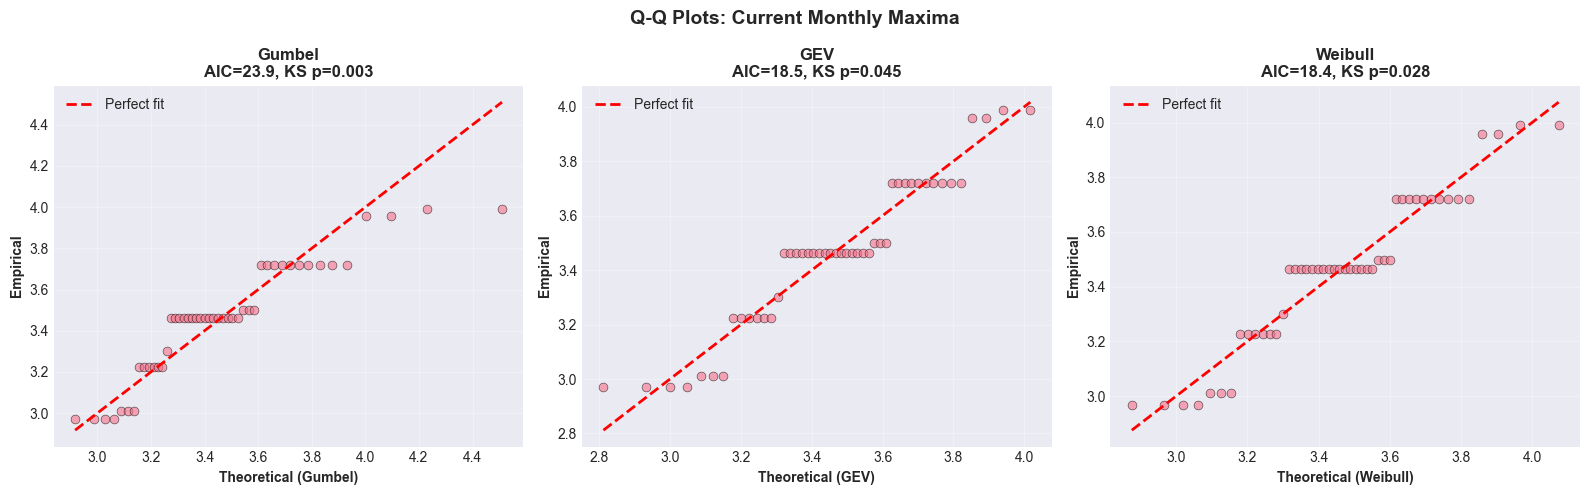


✅ Q-Q plots generated


In [18]:
# Cell 8: Q-Q plots

def plot_qq(data, fit_results, name):
    """Create Q-Q plots for all fitted distributions."""
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    sorted_data = np.sort(data)
    n = len(data)
    empirical_q = (np.arange(1, n+1) - 0.44) / (n + 0.12)  # Gringorten formula
    
    for idx, row in fit_results.iterrows():
        dist_name = row['Distribution']
        params = row['params']
        ax = axes[idx]
        
        if dist_name == 'Gumbel':
            theoretical_q = gumbel_r.ppf(empirical_q, *params)
        elif dist_name == 'GEV':
            theoretical_q = genextreme.ppf(empirical_q, *params)
        else:  # Weibull
            theoretical_q = weibull_min.ppf(empirical_q, *params)
        
        ax.scatter(theoretical_q, sorted_data, alpha=0.6, s=40, edgecolors='k', linewidths=0.5)
        lims = [min(theoretical_q.min(), sorted_data.min()), max(theoretical_q.max(), sorted_data.max())]
        ax.plot(lims, lims, 'r--', linewidth=2, label='Perfect fit')
        ax.set_xlabel(f'Theoretical ({dist_name})', fontweight='bold')
        ax.set_ylabel('Empirical', fontweight='bold')
        ax.set_title(f'{dist_name}\nAIC={row["AIC"]:.1f}, KS p={row["KS p-value"]:.3f}', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Q-Q Plots: {name} Monthly Maxima', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_qq(monthly_maxima_hs.values, fit_results_hs, 'Hs')
plot_qq(monthly_maxima_wind.values, fit_results_wind, 'Wind')
plot_qq(monthly_maxima_current.values, fit_results_current, 'Current')

print("\n✅ Q-Q plots generated")

## PART 4: PEAK-OVER-THRESHOLD (POT) ANALYSIS

In [19]:
# Cell 9: Calculate thresholds (95th percentile)
threshold_hs = np.percentile(df['hs'].dropna(), 95)
threshold_wind = np.percentile(df['wind_speed'].dropna(), 95)
threshold_current = np.percentile(df['current_speed_knots_max'].dropna(), 95)

print("\n" + "="*80)
print("POT THRESHOLDS (95th percentile)")
print("="*80)
print(f"Hs: {threshold_hs:.2f} m")
print(f"Wind: {threshold_wind:.2f} m/s")
print(f"Current: {threshold_current:.2f} kt")


POT THRESHOLDS (95th percentile)
Hs: 2.89 m
Wind: 13.26 m/s
Current: 2.97 kt


In [20]:
# Cell 10: Extract and decluster exceedances

def decluster_exceedances(data_series, threshold, min_sep_hours=48):
    """Extract exceedances and decluster to ensure independence."""
    exceedances_raw = data_series[data_series > threshold]
    
    if len(exceedances_raw) == 0:
        return pd.Series(dtype=float)
    
    declustered = []
    current_cluster = [exceedances_raw.iloc[0]]
    current_idx = [exceedances_raw.index[0]]
    
    for i in range(1, len(exceedances_raw)):
        # Calculate time difference in hours
        time_diff_hours = (exceedances_raw.index[i] - current_idx[-1]).total_seconds() / 3600
        
        if time_diff_hours <= min_sep_hours:
            # Same cluster
            current_cluster.append(exceedances_raw.iloc[i])
            current_idx.append(exceedances_raw.index[i])
        else:
            # New cluster - save max from previous
            max_idx = np.argmax(current_cluster)
            declustered.append((current_idx[max_idx], current_cluster[max_idx]))
            # Start new cluster
            current_cluster = [exceedances_raw.iloc[i]]
            current_idx = [exceedances_raw.index[i]]
    
    # Last cluster
    if len(current_cluster) > 0:
        max_idx = np.argmax(current_cluster)
        declustered.append((current_idx[max_idx], current_cluster[max_idx]))
    
    return pd.Series([val for _, val in declustered], index=[idx for idx, _ in declustered])

# Extract exceedances
exceedances_hs = decluster_exceedances(df['hs'].dropna(), threshold_hs)
exceedances_wind = decluster_exceedances(df['wind_speed'].dropna(), threshold_wind)
exceedances_current = decluster_exceedances(df['current_speed_knots_max'].dropna(), threshold_current)

print("\n" + "="*80)
print("DECLUSTERED EXCEEDANCES")
print("="*80)
print(f"Hs: {(df['hs'] > threshold_hs).sum()} raw → {len(exceedances_hs)} declustered events")
print(f"Wind: {(df['wind_speed'] > threshold_wind).sum()} raw → {len(exceedances_wind)} declustered events")
print(f"Current: {(df['current_speed_knots_max'] > threshold_current).sum()} raw → {len(exceedances_current)} declustered events")


DECLUSTERED EXCEEDANCES
Hs: 793 raw → 191 declustered events
Wind: 793 raw → 230 declustered events
Current: 273 raw → 63 declustered events



GPD FIT: Hs
Threshold: 2.89
N exceedances: 191
Shape (ξ): -0.0775
Scale (σ): 0.9814
KS p-value: 0.8994


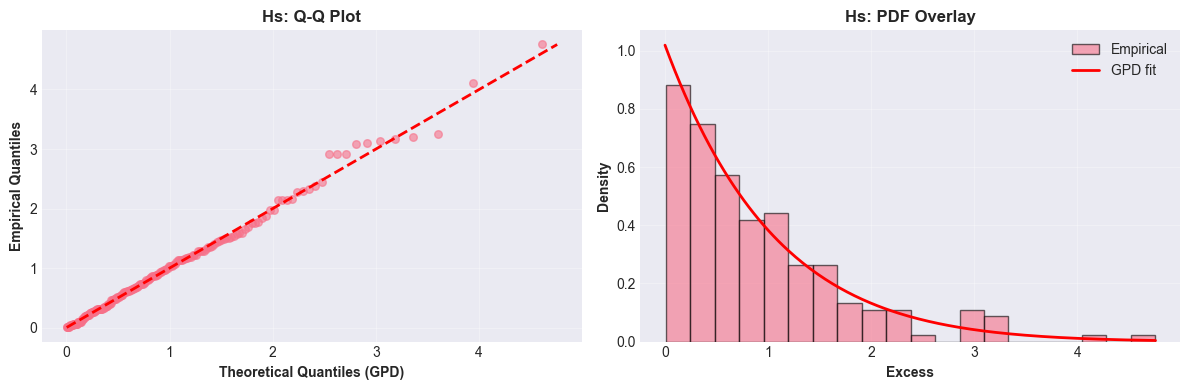


GPD FIT: Wind
Threshold: 13.26
N exceedances: 230
Shape (ξ): -0.1939
Scale (σ): 2.3948
KS p-value: 0.9585


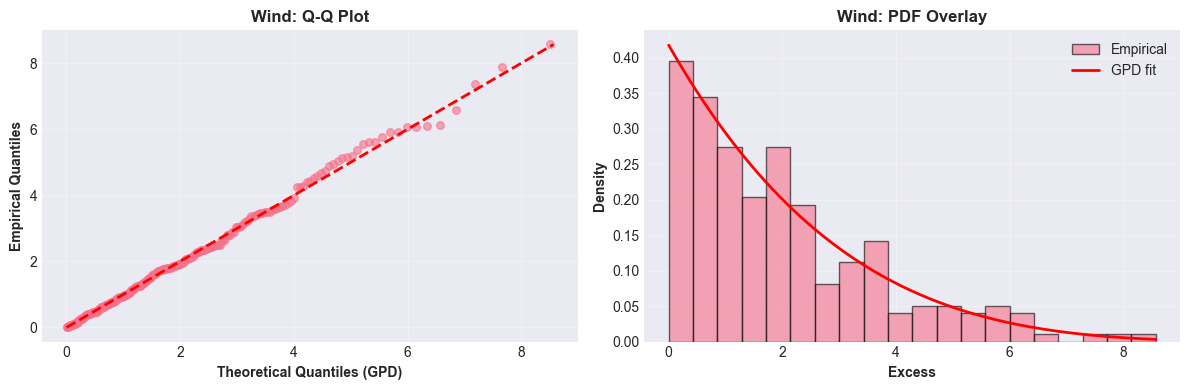


GPD FIT: Current
Threshold: 2.97
N exceedances: 63
Shape (ξ): -0.7745
Scale (σ): 0.8035
KS p-value: 0.0057


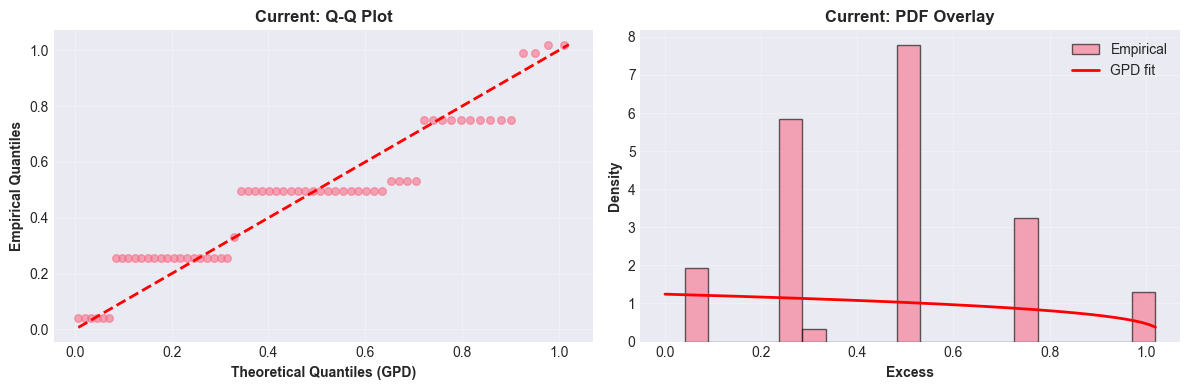


✅ GPD fitting complete


In [21]:
# Cell 11: Fit GPD to exceedances

def fit_gpd(exceedances, threshold, name):
    """Fit Generalized Pareto Distribution."""
    excesses = exceedances - threshold
    shape, loc, scale = genpareto.fit(excesses, floc=0)  # loc=0 for GPD
    
    ks_stat, ks_pval = stats.kstest(excesses, lambda x: genpareto.cdf(x, shape, loc, scale))
    
    print(f"\n{'='*80}")
    print(f"GPD FIT: {name}")
    print(f"{'='*80}")
    print(f"Threshold: {threshold:.2f}")
    print(f"N exceedances: {len(excesses)}")
    print(f"Shape (ξ): {shape:.4f}")
    print(f"Scale (σ): {scale:.4f}")
    print(f"KS p-value: {ks_pval:.4f}")
    
    # Q-Q plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    sorted_excesses = np.sort(excesses)
    n = len(sorted_excesses)
    emp_q = (np.arange(1, n+1) - 0.44) / (n + 0.12)
    theo_q = genpareto.ppf(emp_q, shape, loc, scale)
    
    ax1.scatter(theo_q, sorted_excesses, alpha=0.6, s=30)
    lims = [min(theo_q.min(), sorted_excesses.min()), max(theo_q.max(), sorted_excesses.max())]
    ax1.plot(lims, lims, 'r--', linewidth=2)
    ax1.set_xlabel('Theoretical Quantiles (GPD)', fontweight='bold')
    ax1.set_ylabel('Empirical Quantiles', fontweight='bold')
    ax1.set_title(f'{name}: Q-Q Plot', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    ax2.hist(excesses, bins=20, density=True, alpha=0.6, edgecolor='black', label='Empirical')
    x_range = np.linspace(0, excesses.max(), 200)
    ax2.plot(x_range, genpareto.pdf(x_range, shape, loc, scale), 'r-', linewidth=2, label='GPD fit')
    ax2.set_xlabel('Excess', fontweight='bold')
    ax2.set_ylabel('Density', fontweight='bold')
    ax2.set_title(f'{name}: PDF Overlay', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {'shape': shape, 'scale': scale, 'threshold': threshold, 'n_exceedances': len(excesses)}

# Fit GPD to all variables
gpd_params_hs = fit_gpd(exceedances_hs.values, threshold_hs, 'Hs')
gpd_params_wind = fit_gpd(exceedances_wind.values, threshold_wind, 'Wind')
gpd_params_current = fit_gpd(exceedances_current.values, threshold_current, 'Current')

print("\n✅ GPD fitting complete")

## PART 5: OPERATIONAL EXCEEDANCE PROBABILITIES

In [22]:
# Cell 12: Calculate empirical exceedance probabilities

def calculate_empirical_exceedance(data_series, limit, project_duration_days):
    """
    Calculate exceedance probability using empirical rates from raw data.
    
    This is the CORRECT approach for operational limits that are NOT extreme values.
    
    Logic:
    1. Calculate hourly exceedance rate from raw data: P(X > limit per hour)
    2. Convert to project duration: P(at least one exceedance in N hours)
    """
    # Hourly exceedance rate
    p_hourly = (data_series > limit).sum() / len(data_series)
    
    # Project duration probability (assuming hourly independence)
    # P(at least one exceedance in N hours) = 1 - (1 - p_hourly)^N
    hours = project_duration_days * 24
    p_project = 1 - (1 - p_hourly)**hours
    
    return p_project, p_hourly

# Operational limits
operational_limits = {
    'Hs': {'Crane limit': 1.5, 'Diving limit': 2.0, 'Severe weather': 4.0},
    'Wind': {'High wind': 25.0, 'Storm': 30.0},
    'Current': {'Diving limit': 1.0, 'Severe current': 1.5}
}

project_durations = [14, 30, 60, 90, 180]

print("\n" + "="*80)
print("OPERATIONAL EXCEEDANCE PROBABILITIES (EMPIRICAL METHOD)")
print("="*80)
print("\nNote: Using empirical exceedance rates from raw hourly data.")
print("This is appropriate for operational limits that are NOT extreme values.")
print("="*80)

results_hs = []
results_wind = []
results_current = []

# Hs
print(f"\nHs:")
for limit_name, limit_value in operational_limits['Hs'].items():
    print(f"  {limit_name} (>{limit_value}m):")
    for duration in project_durations:
        p_project, p_hourly = calculate_empirical_exceedance(
            df['hs'].dropna(), limit_value, duration
        )
        results_hs.append({
            'Limit': limit_name,
            'Threshold (m)': limit_value,
            'Project Duration (days)': duration,
            'Exceedance Probability': p_project,
            'Hourly Rate (%)': p_hourly * 100
        })
        print(f"    {duration}d: {p_project*100:.1f}% (hourly rate: {p_hourly*100:.2f}%)")

# Wind
print(f"\nWind:")
for limit_name, limit_value in operational_limits['Wind'].items():
    print(f"  {limit_name} (>{limit_value}m/s):")
    for duration in project_durations:
        p_project, p_hourly = calculate_empirical_exceedance(
            df['wind_speed'].dropna(), limit_value, duration
        )
        results_wind.append({
            'Limit': limit_name,
            'Threshold (m/s)': limit_value,
            'Project Duration (days)': duration,
            'Exceedance Probability': p_project,
            'Hourly Rate (%)': p_hourly * 100
        })
        print(f"    {duration}d: {p_project*100:.1f}% (hourly rate: {p_hourly*100:.2f}%)")

# Current
print(f"\nCurrent:")
for limit_name, limit_value in operational_limits['Current'].items():
    print(f"  {limit_name} (>{limit_value}kt):")
    for duration in project_durations:
        p_project, p_hourly = calculate_empirical_exceedance(
            df['current_speed_knots_max'].dropna(), limit_value, duration
        )
        results_current.append({
            'Limit': limit_name,
            'Threshold (kt)': limit_value,
            'Project Duration (days)': duration,
            'Exceedance Probability': p_project,
            'Hourly Rate (%)': p_hourly * 100
        })
        print(f"    {duration}d: {p_project*100:.1f}% (hourly rate: {p_hourly*100:.2f}%)")

print("\n" + "-"*80)
print("INTERPRETATION:")
print("-"*80)
print("These probabilities answer: 'What is the probability of experiencing")
print("at least ONE hour exceeding the limit during the project duration?'")
print("\nFor workability analysis (Phase 2), you should use the hourly rates directly.")
print("="*80)


OPERATIONAL EXCEEDANCE PROBABILITIES (EMPIRICAL METHOD)

Note: Using empirical exceedance rates from raw hourly data.
This is appropriate for operational limits that are NOT extreme values.

Hs:
  Crane limit (>1.5m):
    14d: 100.0% (hourly rate: 32.62%)
    30d: 100.0% (hourly rate: 32.62%)
    60d: 100.0% (hourly rate: 32.62%)
    90d: 100.0% (hourly rate: 32.62%)
    180d: 100.0% (hourly rate: 32.62%)
  Diving limit (>2.0m):
    14d: 100.0% (hourly rate: 16.75%)
    30d: 100.0% (hourly rate: 16.75%)
    60d: 100.0% (hourly rate: 16.75%)
    90d: 100.0% (hourly rate: 16.75%)
    180d: 100.0% (hourly rate: 16.75%)
  Severe weather (>4.0m):
    14d: 98.4% (hourly rate: 1.22%)
    30d: 100.0% (hourly rate: 1.22%)
    60d: 100.0% (hourly rate: 1.22%)
    90d: 100.0% (hourly rate: 1.22%)
    180d: 100.0% (hourly rate: 1.22%)

Wind:
  High wind (>25.0m/s):
    14d: 0.0% (hourly rate: 0.00%)
    30d: 0.0% (hourly rate: 0.00%)
    60d: 0.0% (hourly rate: 0.00%)
    90d: 0.0% (hourly rate: 

## PART 6: VISUALIZATION

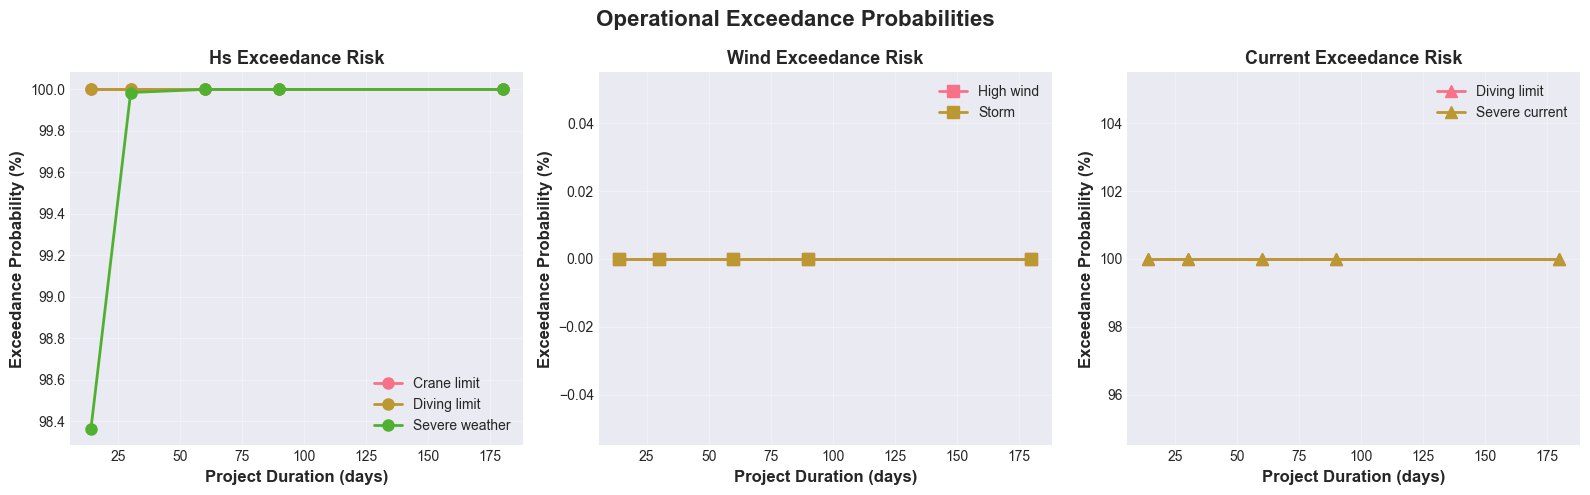

✅ Exceedance probability curves plotted


In [23]:
# Cell 13: Exceedance probability curves
df_hs = pd.DataFrame(results_hs)
df_wind = pd.DataFrame(results_wind)
df_current = pd.DataFrame(results_current)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Hs
for limit in df_hs['Limit'].unique():
    subset = df_hs[df_hs['Limit'] == limit]
    axes[0].plot(subset['Project Duration (days)'], subset['Exceedance Probability'] * 100, 
                 'o-', linewidth=2, markersize=8, label=limit)
axes[0].set_xlabel('Project Duration (days)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Exceedance Probability (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Hs Exceedance Risk', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Wind
for limit in df_wind['Limit'].unique():
    subset = df_wind[df_wind['Limit'] == limit]
    axes[1].plot(subset['Project Duration (days)'], subset['Exceedance Probability'] * 100, 
                 's-', linewidth=2, markersize=8, label=limit)
axes[1].set_xlabel('Project Duration (days)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Exceedance Probability (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Wind Exceedance Risk', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Current
for limit in df_current['Limit'].unique():
    subset = df_current[df_current['Limit'] == limit]
    axes[2].plot(subset['Project Duration (days)'], subset['Exceedance Probability'] * 100, 
                 '^-', linewidth=2, markersize=8, label=limit)
axes[2].set_xlabel('Project Duration (days)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Exceedance Probability (%)', fontsize=12, fontweight='bold')
axes[2].set_title('Current Exceedance Risk', fontsize=13, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Operational Exceedance Probabilities', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Exceedance probability curves plotted")

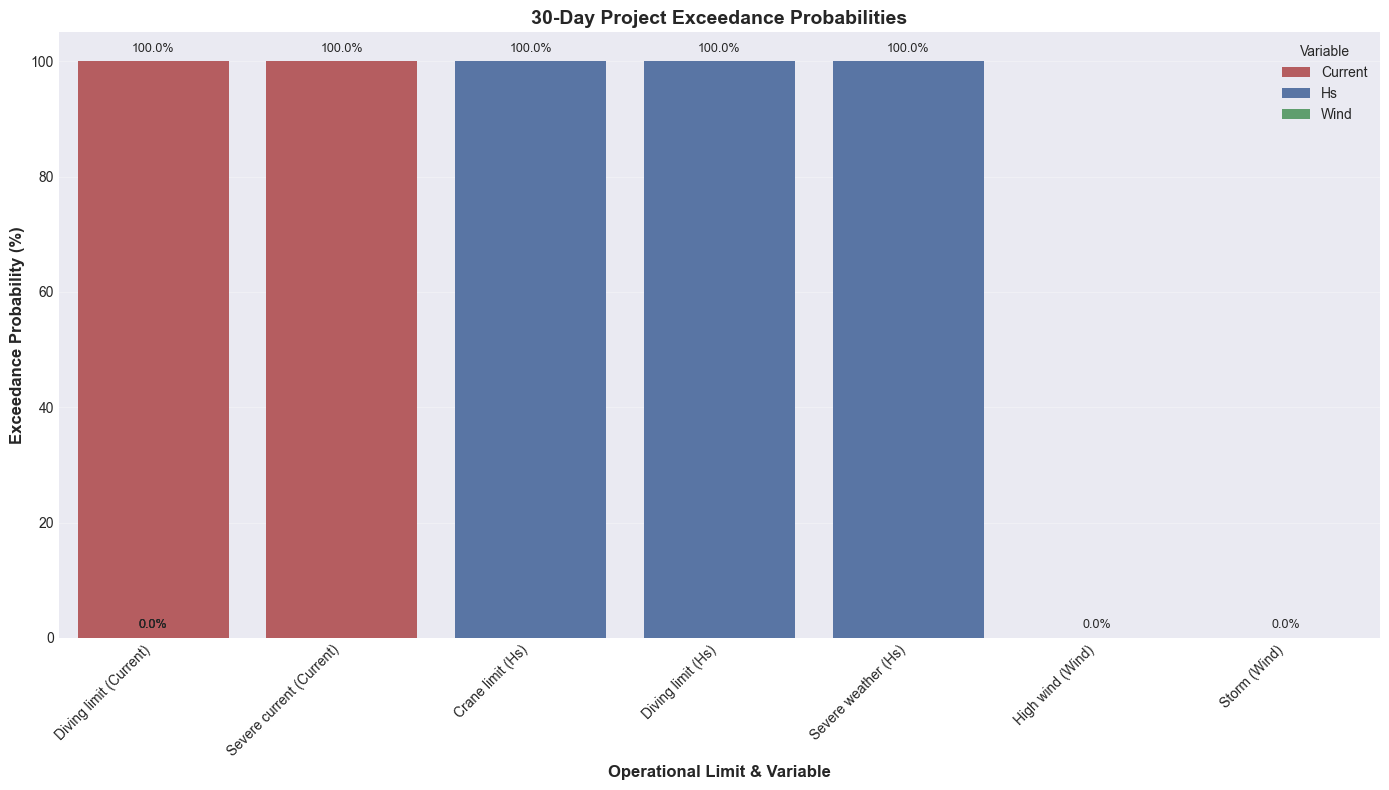

✅ 30-day comparison plotted


In [25]:
# Cell 14: 30-day comparison
hs_30 = df_hs[df_hs['Project Duration (days)'] == 30]
wind_30 = df_wind[df_wind['Project Duration (days)'] == 30]
current_30 = df_current[df_current['Project Duration (days)'] == 30]

# Combine data for a clearer plot, as limits are not 1-to-1
plot_data = pd.concat([
    hs_30[['Limit', 'Exceedance Probability']].assign(Variable='Hs'),
    wind_30[['Limit', 'Exceedance Probability']].assign(Variable='Wind'),
    current_30[['Limit', 'Exceedance Probability']].assign(Variable='Current')
])

# Create a unique label for each bar
plot_data['Label'] = plot_data['Limit'] + ' (' + plot_data['Variable'] + ')'
# Sort by variable then probability for a more organized plot
plot_data.sort_values(['Variable', 'Exceedance Probability'], ascending=[True, False], inplace=True)


fig, ax = plt.subplots(figsize=(14, 8)) # Adjusted for more labels

# Use seaborn for easier plotting with categorical data
sns.barplot(data=plot_data, x='Label', y=plot_data['Exceedance Probability'] * 100, hue='Variable', ax=ax, dodge=False, palette={'Hs': '#4c72b0', 'Wind': '#55a868', 'Current': '#c44e52'})

ax.set_xlabel('Operational Limit & Variable', fontsize=12, fontweight='bold')
ax.set_ylabel('Exceedance Probability (%)', fontsize=12, fontweight='bold')
ax.set_title('30-Day Project Exceedance Probabilities', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right') # Rotate labels for better fit
ax.legend(title='Variable')
ax.grid(True, axis='y', alpha=0.3)

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize=9)

plt.tight_layout()
plt.show()

print("✅ 30-day comparison plotted")

## PART 7: SUMMARY & SAVE

In [26]:
# Cell 15: Print summary
print("\n" + "="*80)
print("PHASE 4A SUMMARY")
print("="*80)

print("\n" + "-"*80)
print("BEST-FIT DISTRIBUTIONS (Monthly Maxima)")
print("-"*80)
summary_table = pd.DataFrame([
    {'Variable': 'Hs', 'N': len(monthly_maxima_hs), 'Distribution': best_dist_hs['Distribution'], 'AIC': best_dist_hs['AIC']},
    {'Variable': 'Wind', 'N': len(monthly_maxima_wind), 'Distribution': best_dist_wind['Distribution'], 'AIC': best_dist_wind['AIC']},
    {'Variable': 'Current', 'N': len(monthly_maxima_current), 'Distribution': best_dist_current['Distribution'], 'AIC': best_dist_current['AIC']}
])
display(summary_table)

print("\n" + "-"*80)
print("POT PARAMETERS")
print("-"*80)
pot_table = pd.DataFrame([
    {'Variable': 'Hs', 'Threshold': gpd_params_hs['threshold'], 'N Exceedances': gpd_params_hs['n_exceedances'], 
     'GPD Shape': gpd_params_hs['shape'], 'GPD Scale': gpd_params_hs['scale']},
    {'Variable': 'Wind', 'Threshold': gpd_params_wind['threshold'], 'N Exceedances': gpd_params_wind['n_exceedances'],
     'GPD Shape': gpd_params_wind['shape'], 'GPD Scale': gpd_params_wind['scale']},
    {'Variable': 'Current', 'Threshold': gpd_params_current['threshold'], 'N Exceedances': gpd_params_current['n_exceedances'],
     'GPD Shape': gpd_params_current['shape'], 'GPD Scale': gpd_params_current['scale']}
])
display(pot_table)

print("\n" + "-"*80)
print("KEY INSIGHTS (30-day project)")
print("-"*80)

crane_30 = hs_30[hs_30['Threshold (m)'] == 1.5]['Exceedance Probability'].values[0]
diving_30_hs = hs_30[hs_30['Threshold (m)'] == 2.0]['Exceedance Probability'].values[0]
diving_30_current = current_30[current_30['Threshold (kt)'] == 1.0]['Exceedance Probability'].values[0]

print(f"\n🏗️  Crane Operations:")
print(f"   Hs risk (>1.5m): {crane_30*100:.1f}%")

print(f"\n🤿 Diving Operations:")
print(f"   Hs risk (>2.0m): {diving_30_hs*100:.1f}%")
print(f"   Current risk (>1.0kt): {diving_30_current*100:.1f}%")

if diving_30_current > diving_30_hs:
    print(f"   ⚠️  CRITICAL: Current is the PRIMARY constraint ({diving_30_current/diving_30_hs:.1f}x higher risk than Hs!)")
    print(f"   → This explains why diving workability drops from 67% to 2% in Phase 2!")

print("\n" + "="*80)


PHASE 4A SUMMARY

--------------------------------------------------------------------------------
BEST-FIT DISTRIBUTIONS (Monthly Maxima)
--------------------------------------------------------------------------------


,Variable,N,Distribution,AIC
0,Hs,131,Weibull,417.029
1,Wind,131,Weibull,622.665
2,Current,47,Weibull,18.398



--------------------------------------------------------------------------------
POT PARAMETERS
--------------------------------------------------------------------------------


,Variable,Threshold,N Exceedances,GPD Shape,GPD Scale
0,Hs,2.893,191,-0.077,0.981
1,Wind,13.258,230,-0.194,2.395
2,Current,2.969,63,-0.774,0.804



--------------------------------------------------------------------------------
KEY INSIGHTS (30-day project)
--------------------------------------------------------------------------------

🏗️  Crane Operations:
   Hs risk (>1.5m): 100.0%

🤿 Diving Operations:
   Hs risk (>2.0m): 100.0%
   Current risk (>1.0kt): 100.0%



In [27]:
# Cell 16: Save results
os.makedirs('../data/processed/phase4a', exist_ok=True)

# Save distribution parameters
eva_distributions = {
    'hs': {
        'monthly_maxima': {
            'distribution': best_dist_hs['Distribution'],
            'params': best_dist_hs['params'],
            'aic': best_dist_hs['AIC'],
            'ks_pvalue': best_dist_hs['KS p-value']
        },
        'pot': gpd_params_hs,
        'sample_size': len(monthly_maxima_hs)
    },
    'wind': {
        'monthly_maxima': {
            'distribution': best_dist_wind['Distribution'],
            'params': best_dist_wind['params'],
            'aic': best_dist_wind['AIC'],
            'ks_pvalue': best_dist_wind['KS p-value']
        },
        'pot': gpd_params_wind,
        'sample_size': len(monthly_maxima_wind)
    },
    'current': {
        'monthly_maxima': {
            'distribution': best_dist_current['Distribution'],
            'params': best_dist_current['params'],
            'aic': best_dist_current['AIC'],
            'ks_pvalue': best_dist_current['KS p-value']
        },
        'pot': gpd_params_current,
        'sample_size': len(monthly_maxima_current)
    }
}

with open('../data/processed/phase4a/eva_distributions.pkl', 'wb') as f:
    pickle.dump(eva_distributions, f)

# Save exceedance probabilities
df_hs.to_csv('../data/processed/phase4a/exceedance_probabilities_hs.csv', index=False)
df_wind.to_csv('../data/processed/phase4a/exceedance_probabilities_wind.csv', index=False)
df_current.to_csv('../data/processed/phase4a/exceedance_probabilities_current.csv', index=False)

print("\n" + "="*80)
print("✅ PHASE 4A COMPLETE!")
print("="*80)
print("\nSaved to: data/processed/phase4a/")
print("  • eva_distributions.pkl")
print("  • exceedance_probabilities_hs.csv")
print("  • exceedance_probabilities_wind.csv")
print("  • exceedance_probabilities_current.csv")
print("\n🎯 Ready for Phase 4B: Bivariate EVA + Copula Integration")


✅ PHASE 4A COMPLETE!

Saved to: data/processed/phase4a/
  • eva_distributions.pkl
  • exceedance_probabilities_hs.csv
  • exceedance_probabilities_wind.csv
  • exceedance_probabilities_current.csv

🎯 Ready for Phase 4B: Bivariate EVA + Copula Integration
